In [1]:
from cloudvolume import CloudVolume
from caveclient import CAVEclient
import navis
from navis import TreeNeuron
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import json
import uuid  
from datetime import datetime
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from scipy.spatial import distance, distance_matrix, cKDTree
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy import stats
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import cloudvolume as cv
from collections import Counter
from collections import defaultdict

navis.patch_cloudvolume()

vol = cv.CloudVolume("precomputed://gs://zheng_mouse_hippocampus_production/v2/seg_m195", use_https=True, progress=False) # new from Will
seg = cv.CloudVolume("graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3", use_https=True) # old

client = CAVEclient('zheng_ca3')
auth = client.auth

# CloudVolume and Cave setup
sv = CloudVolume('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', use_https=True, lru_bytes=int(1e8))

INFO  : cloud-volume successfully patched! (navis)


## Further Processing Spines

In [2]:
def count_presynaptic_partners(df, save_filename):
    # Safe function to process each row
    def process_pre_partners_ids(partner_list):
        # Handle NaN or unexpected types
        if pd.isna(partner_list) or not isinstance(partner_list, (str, list)):
            return [], [], 0

        # If stored as string, evaluate it to convert to list
        if isinstance(partner_list, str):
            try:
                partner_list = eval(partner_list)
            except Exception:
                return [], [], 0  # In case eval fails

        # If it's still not a list after eval
        if not isinstance(partner_list, list):
            return [], [], 0

        count_dict = Counter(partner_list)
        unique_values = list(count_dict.keys())
        counts = list(count_dict.values())

        return unique_values, counts, len(unique_values)

    # Apply the function safely
    df[['pre_partners_ids', 'num_sym_per_pre_partner', 'unique_partner_num']] = df['pre_partners_ids'].apply(
        lambda x: pd.Series(process_pre_partners_ids(x))
    )

    # Optional renaming
    if 'pre_partner_num' in df.columns:
        df.rename(columns={'pre_partner_num': 'pre_partner_num_syn'}, inplace=True)

    # Move 'date' column to end
    if 'date' in df.columns:
        columns = [col for col in df.columns if col != 'date'] + ['date']
        df = df[columns]
        
    # Preallocate an array for performance
    synapse_num_list = np.zeros(len(df), dtype=int)

    # Iterate efficiently using itertuples()
    for idx, row in tqdm(enumerate(df.itertuples(index=False)), total=len(df), desc="Processing SegIDs"):
        segid = row.segid  # Access 'segid' column efficiently

        df_synapses = client.materialize.synapse_query(
            pre_ids=None, 
            post_ids=segid,              
            synapse_table="synapses_ca3_v1",
            desired_resolution=[18, 18, 45]
        )

        synapse_num_list[idx] = len(df_synapses)  # Store directly in preallocated array

    # Assign array to DataFrame
    df['total_num_synapses'] = synapse_num_list
    
    def move_column(df, column_name, before_column):
        cols = df.columns.tolist()  # Get list of columns
        cols.remove(column_name)  # Remove the column we want to move
        insert_idx = cols.index(before_column)  # Find where to insert it
        cols.insert(insert_idx, column_name)  # Insert at the correct position
        return df[cols]  # Reorder DataFrame

    df = move_column(df, 'total_num_synapses', "num_sym_per_pre_partner")
    df.rename(columns={'num_sym_per_pre_partner': 'num_syn_per_pre_partner'}, inplace=True)
    
    df.to_csv(save_filename)

    return df

def find_only_pre_partners(df, save_filename, graph=True):
    # Make a copy of the original DataFrame to avoid modifying it
    df_copy = df.copy()

    # If your 'pre_partners_ids' values are strings, convert them to lists
    def safe_eval(val):
        if isinstance(val, str):
            return eval(val)
        return val

    # Apply safe eval to ensure they're proper lists
    df_copy['pre_partners_ids'] = df_copy['pre_partners_ids'].apply(safe_eval)

    # Dictionary to track: {pre_partner_id: set of segids}
    partner_to_segids = defaultdict(set)

    # Dictionary to count how many rows each ID appears in
    partner_to_count = defaultdict(int)

    # Iterate through each row
    for _, row in df_copy.iterrows():
        segid = row['segid']
        partner_ids = row['pre_partners_ids']

        for partner_id in set(partner_ids):  # Use set to avoid double-counting within same row
            partner_to_count[partner_id] += 1
            partner_to_segids[partner_id].add(segid)

    # Build the result DataFrame
    result_df_pre = pd.DataFrame({
        'pre_partner_id': list(partner_to_count.keys()),
        'num_apical_synaptic_partners': list(partner_to_count.values()),
        'segids_connected_to': [list(v) for v in partner_to_segids.values()]
    })
    
    if graph:
        # Plot histogram of how often each pre_partner_id was found
        plt.figure(figsize=(10, 6))
        plt.hist(result_df_pre['num_apical_synaptic_partners'], bins=30, color='skyblue', edgecolor='black')

        plt.xlabel('Number of Apical Partners')
        plt.ylabel('Frequency')
        plt.title('Histogram of pre_partner_id Occurrence Across Rows')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # save file     
    result_df_pre.to_csv(save_filename)
    
    return result_df_pre

## Graphing Data

### Bar plot sorted by topographic location along CA3 curve

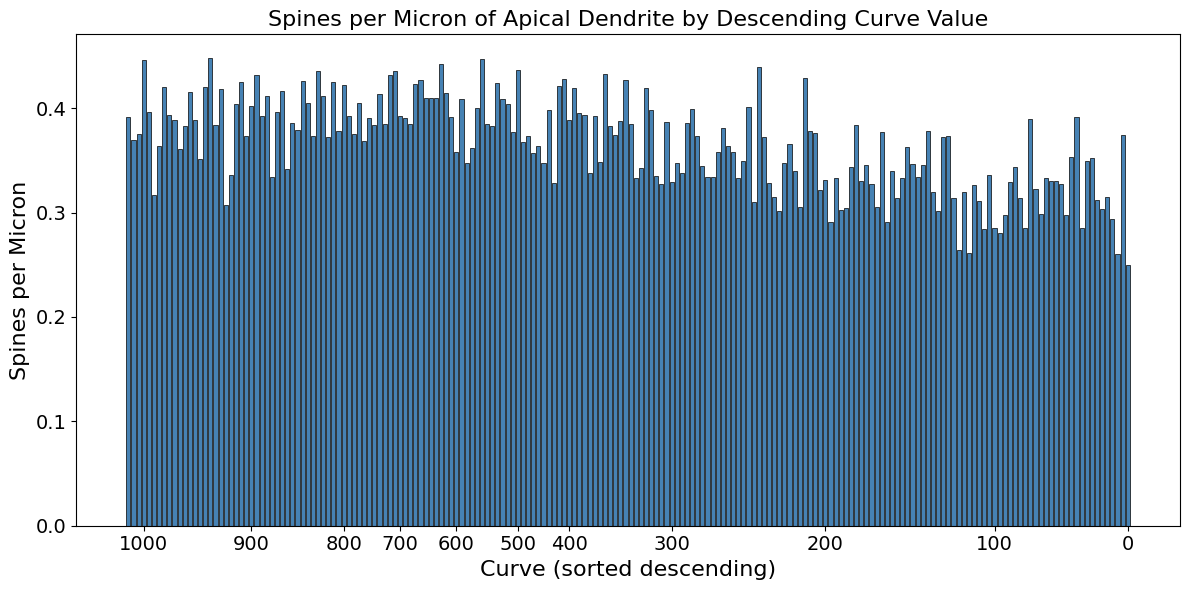

In [13]:
# Graphing Bar Chart From Google Sheet
current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD

df_results = pd.read_csv('Apical_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 100]
# -----------------------------------------------------------------------------
# 1. Prepare and sort your data
# -----------------------------------------------------------------------------
# Example DataFrame: Replace this with your real data
df = df_results

# Drop rows where 'curve' is missing, if any
df = df.dropna(subset=['curve'])
df = df[df['spines_per_micron'].notna()] 
df = df[df['spines_per_micron'] != 0]
#df = df[df['segid'] != 648518346449439091]
#df = df[df['segid'] != 648518346440647718]


# Sort in descending order by 'curve' so largest is first (leftmost bar)
df_sorted = df.sort_values(by='curve', ascending=False).reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. Set up x positions as a simple integer range for uniform bar widths
# -----------------------------------------------------------------------------
x_positions = np.arange(len(df_sorted))  # [0, 1, 2, 3, ...]

# Extract the data to plot
y_values = df_sorted['spines_per_micron'].values
curve_values = df_sorted['curve'].values

# -----------------------------------------------------------------------------
# 3. Plot bars with uniform width
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(x_positions, y_values, width=0.8, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Curve (sorted descending)', fontsize=16)
plt.ylabel('Spines per Micron', fontsize=16)
plt.title('Spines per Micron of Apical Dendrite by Descending Curve Value', fontsize = 16)

# -----------------------------------------------------------------------------
# 4. Create x-axis ticks for multiples of 100 (approximate curve scale)
# -----------------------------------------------------------------------------
max_curve = curve_values[0]  # largest curve (since we sorted descending)
min_curve = curve_values[-1] # smallest curve

# Round them to nearest hundreds for start/end
start = int(np.floor(max_curve / 100.0) * 100)
end   = int(np.floor(min_curve / 100.0) * 100)

# Generate multiples of 100 in descending order
if end < 0:
    end = 0  # just to avoid negative stepping issues if your data is small

tick_values = np.arange(start, end - 1, -100)  # e.g., 1100, 1000, 900, ...

tick_positions = []
tick_labels = []

for val in tick_values:
    # Find the index of the bar whose 'curve' is closest to 'val'
    idx_closest = np.argmin(np.abs(curve_values - val))
    tick_positions.append(idx_closest)
    tick_labels.append(str(val))

# Now set the tick marks
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(fontsize=14)

# Add labels and legend
#plt.legend(fontsize=14)
plt.savefig(f'SPM_ApicalPyr__hist_{current_date}_100.png', dpi=600)

plt.tight_layout()
plt.show()

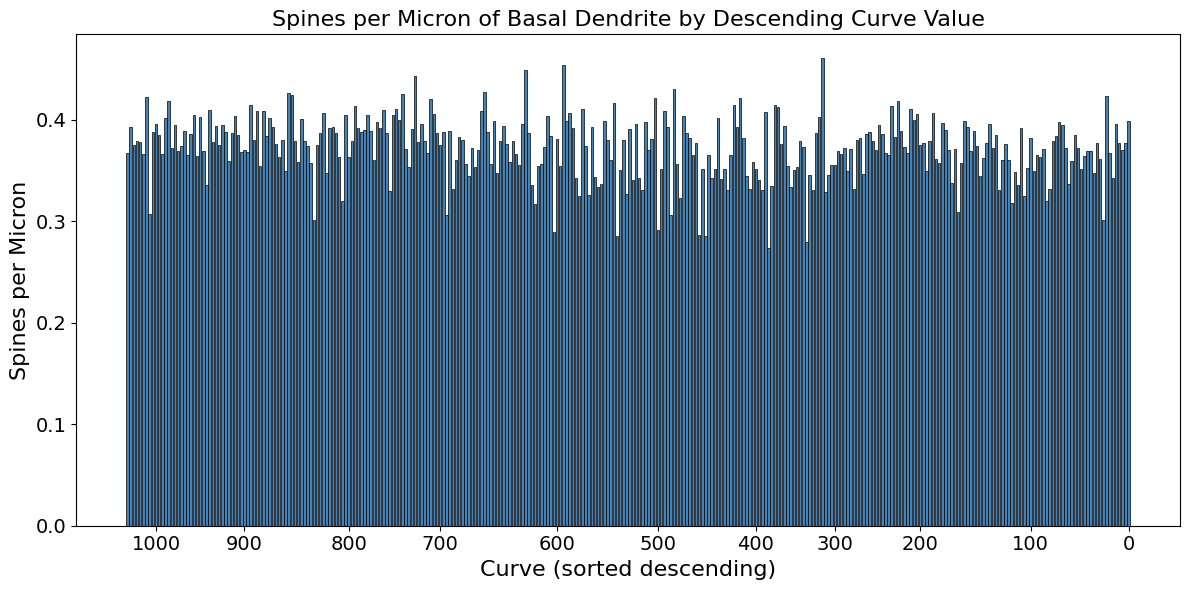

In [20]:
# Graphing Bar Chart From Google Sheet
current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD

df_results = pd.read_csv('Basal_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 150]
# -----------------------------------------------------------------------------
# 1. Prepare and sort your data
# -----------------------------------------------------------------------------
# Example DataFrame: Replace this with your real data
df = df_results

# Drop rows where 'curve' is missing, if any
df = df.dropna(subset=['curve'])
df = df[df['spines_per_micron'].notna()] 
df = df[df['spines_per_micron'] != 0]
#df = df[df['segid'] != 648518346449439091]
#df = df[df['segid'] != 648518346440647718]


# Sort in descending order by 'curve' so largest is first (leftmost bar)
df_sorted = df.sort_values(by='curve', ascending=False).reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. Set up x positions as a simple integer range for uniform bar widths
# -----------------------------------------------------------------------------
x_positions = np.arange(len(df_sorted))  # [0, 1, 2, 3, ...]

# Extract the data to plot
y_values = df_sorted['spines_per_micron'].values
curve_values = df_sorted['curve'].values

# -----------------------------------------------------------------------------
# 3. Plot bars with uniform width
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.bar(x_positions, y_values, width=0.8, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Curve (sorted descending)', fontsize=16)
plt.ylabel('Spines per Micron', fontsize=16)
plt.title('Spines per Micron of Basal Dendrite by Descending Curve Value', fontsize = 16)

# -----------------------------------------------------------------------------
# 4. Create x-axis ticks for multiples of 100 (approximate curve scale)
# -----------------------------------------------------------------------------
max_curve = curve_values[0]  # largest curve (since we sorted descending)
min_curve = curve_values[-1] # smallest curve

# Round them to nearest hundreds for start/end
start = int(np.floor(max_curve / 100.0) * 100)
end   = int(np.floor(min_curve / 100.0) * 100)

# Generate multiples of 100 in descending order
if end < 0:
    end = 0  # just to avoid negative stepping issues if your data is small

tick_values = np.arange(start, end - 1, -100)  # e.g., 1100, 1000, 900, ...

tick_positions = []
tick_labels = []

for val in tick_values:
    # Find the index of the bar whose 'curve' is closest to 'val'
    idx_closest = np.argmin(np.abs(curve_values - val))
    tick_positions.append(idx_closest)
    tick_labels.append(str(val))

# Now set the tick marks
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(fontsize=14)

# Add labels and legend
#plt.legend(fontsize=14)
plt.savefig(f'SPM_BasalPyr__hist_{current_date}_150.png', dpi=600)

plt.tight_layout()
plt.show()

### Graph Spines per Micron along the Curve of CA3 with Linear Regression Line 

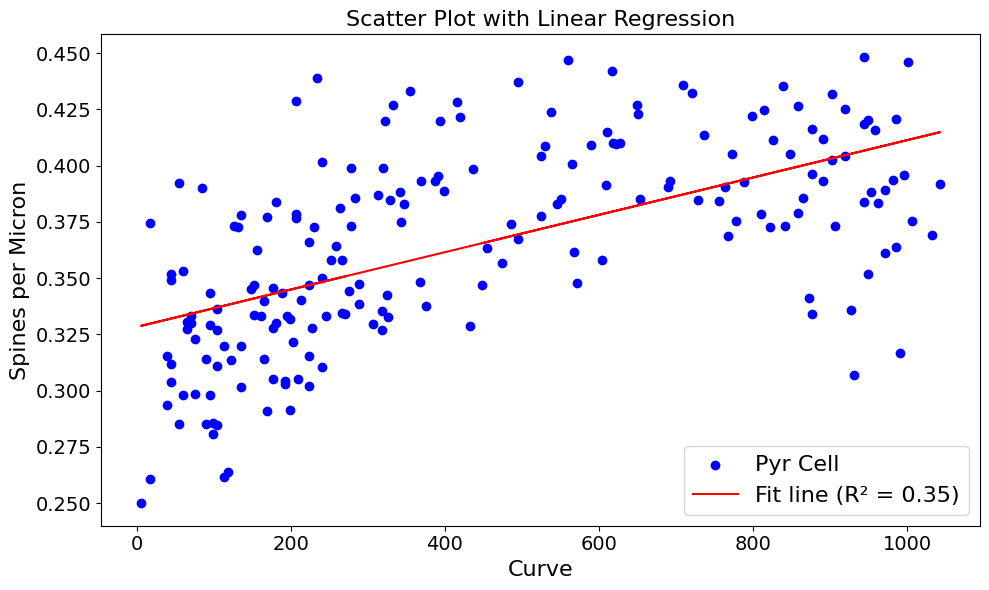

Linear Regression (Pearson) Results:
  Pearson correlation coefficient: 0.60
  R-squared: 0.35
  P-value: 0.0000000000000000000330763

Spearman's Rank Correlation Results:
  Spearman correlation coefficient: 0.64
  Spearman P-value: 0.00000000000000000000000494


In [15]:
# Graphing Dot Plot with Regression From Google Sheet
# Example DataFrame: Replace this with your actual data
current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD

df_results = pd.read_csv('Apical_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 100]
df = df_results


# Drop rows with missing values in either column
df = df.dropna(subset=['curve', 'spines_per_micron'])
df = df[df['spines_per_micron'].notna()] 
df = df[df['spines_per_micron'] != 0]

# 1. Scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(df['curve'], df['spines_per_micron'], color='blue', label='Pyr Cell')

# 2. Perform linear regression using SciPy's linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(df['curve'], df['spines_per_micron'])
# Generate the regression line
regression_line = slope * df['curve'] + intercept

# Plot the regression line
plt.plot(df['curve'], regression_line, color='red',
         label=f'Fit line (R² = {r_value**2:.2f})')

# 3. Add labels and title
plt.xlabel('Curve', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Spines per Micron', fontsize=16)
plt.title('Scatter Plot with Linear Regression', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(f'SPM_ApicalPyr__scatterregression_{current_date}_100.png', dpi=600)
plt.show()

# 4. Print the correlation and regression statistics
print("Linear Regression (Pearson) Results:")
print(f"  Pearson correlation coefficient: {r_value:.2f}")
print(f"  R-squared: {r_value**2:.2f}")
print(f"  P-value: {p_value:.25f}")

# 5. Additionally, compute Spearman's rank correlation (non-parametric)
spearman_corr, spearman_p = stats.spearmanr(df['curve'], df['spines_per_micron'])
print("\nSpearman's Rank Correlation Results:")
print(f"  Spearman correlation coefficient: {spearman_corr:.2f}")
print(f"  Spearman P-value: {spearman_p:.26f}")

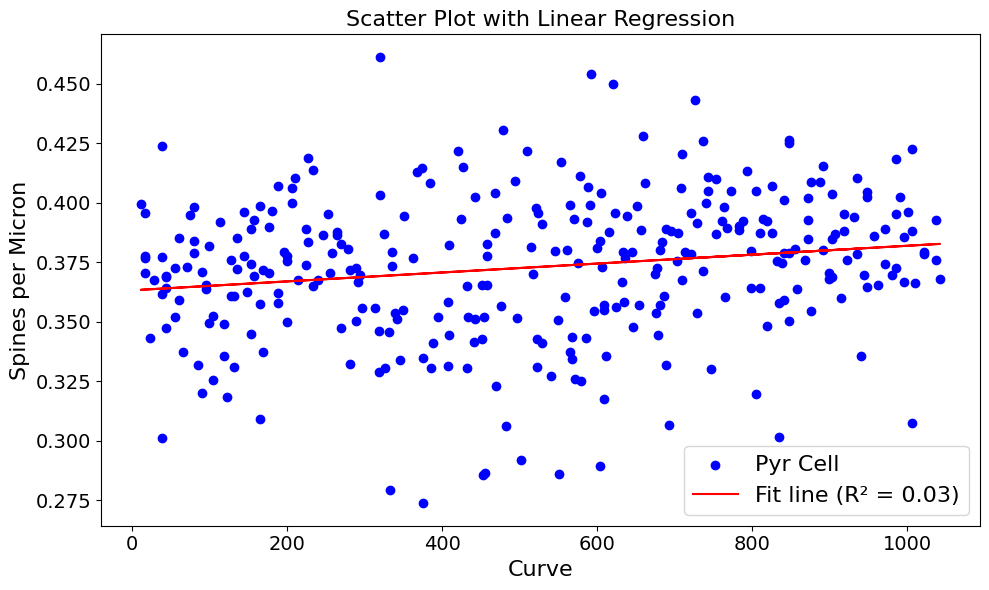

Linear Regression (Pearson) Results:
  Pearson correlation coefficient: 0.18
  R-squared: 0.03
  P-value: 0.0011014316724373249441193

Spearman's Rank Correlation Results:
  Spearman correlation coefficient: 0.21
  Spearman P-value: 0.00012863619294984314825846


In [21]:
# Graphing Dot Plot with Regression From Google Sheet
# Example DataFrame: Replace this with your actual data
current_date = datetime.now().strftime('%Y%m%d')  # Format: YYYYMMDD

df_results = pd.read_csv('Basal_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 150]
df = df_results

# Drop rows with missing values in either column
df = df.dropna(subset=['curve', 'spines_per_micron'])
df = df[df['spines_per_micron'].notna()] 
df = df[df['spines_per_micron'] != 0]

# 1. Scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(df['curve'], df['spines_per_micron'], color='blue', label='Pyr Cell')

# 2. Perform linear regression using SciPy's linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(df['curve'], df['spines_per_micron'])
# Generate the regression line
regression_line = slope * df['curve'] + intercept

# Plot the regression line
plt.plot(df['curve'], regression_line, color='red',
         label=f'Fit line (R² = {r_value**2:.2f})')

# 3. Add labels and title
plt.xlabel('Curve', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Spines per Micron', fontsize=16)
plt.title('Scatter Plot with Linear Regression', fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig(f'SPM_BasalPyr__scatterregression_{current_date}_150.png', dpi=600)
plt.show()

# 4. Print the correlation and regression statistics
print("Linear Regression (Pearson) Results:")
print(f"  Pearson correlation coefficient: {r_value:.2f}")
print(f"  R-squared: {r_value**2:.2f}")
print(f"  P-value: {p_value:.25f}")

# 5. Additionally, compute Spearman's rank correlation (non-parametric)
spearman_corr, spearman_p = stats.spearmanr(df['curve'], df['spines_per_micron'])
print("\nSpearman's Rank Correlation Results:")
print(f"  Spearman correlation coefficient: {spearman_corr:.2f}")
print(f"  Spearman P-value: {spearman_p:.26f}")

### Graph Locations of Soma with Apical Density in Color Bar and Dot Size

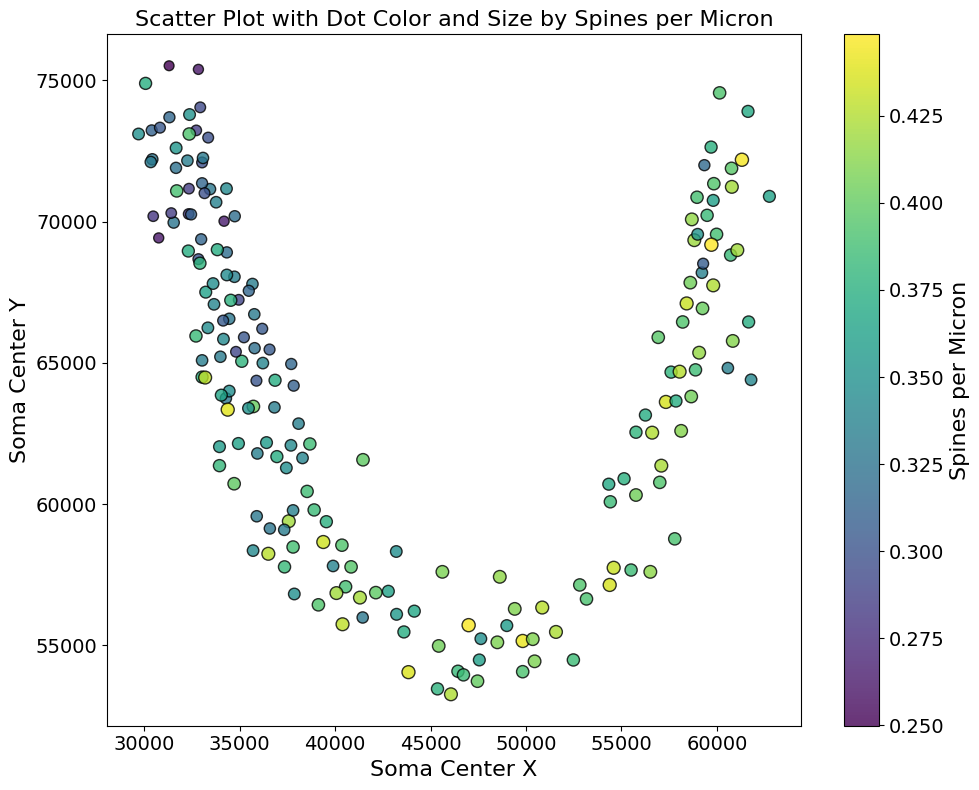

In [17]:
# Graphing Scatter Plot with Regression From Google Sheet
# Example DataFrame (replace this with your actual data)
df_results = pd.read_csv('Apical_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 100]
df = df_results

# Optionally, drop any rows with missing values
df = df.dropna(subset=['soma_center_x', 'soma_center_y', 'spines_per_micron'])

plt.figure(figsize=(10, 8))

# Scale marker size by spines_per_micron; adjust the factor as needed.
size_scale = 200

scatter = plt.scatter(
    df['soma_center_x']/18,
    df['soma_center_y']/18,
    c=df['spines_per_micron'],         # Color mapped to spines_per_micron
    cmap='viridis',                    # You can choose other colormaps if desired
    s=df['spines_per_micron'] * size_scale,  # Size scaled by spines_per_micron
    alpha=0.8,
    edgecolor='black'                  # Optionally add edge for better visibility
)

# Add a colorbar to display the scale of spines_per_micron
cbar = plt.colorbar(scatter)
cbar.set_label('Spines per Micron', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

plt.xlabel('Soma Center X', fontsize=16)
plt.ylabel('Soma Center Y', fontsize=16)
plt.title('Scatter Plot with Dot Color and Size by Spines per Micron', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'SPM_ApicalPyr_DotplotColorbar_{current_date}_100.png', dpi=600)
plt.show()

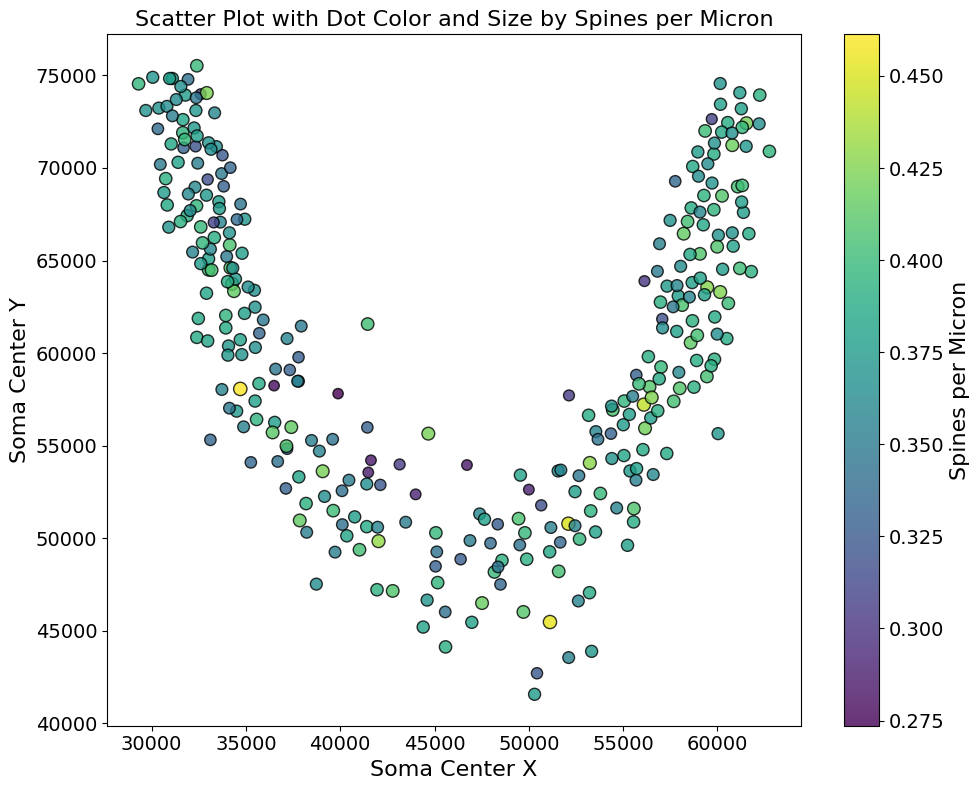

In [22]:
# Graphing Scatter Plot with Regression From Google Sheet
# Example DataFrame (replace this with your actual data)
df_results = pd.read_csv('Basal_Dendrite_Spines_Per_Micron_Filtered_250414.csv')
df_results = df_results[df_results['spines_num'] >= 150]
df = df_results

# Optionally, drop any rows with missing values
df = df.dropna(subset=['soma_center_x', 'soma_center_y', 'spines_per_micron'])

plt.figure(figsize=(10, 8))

# Scale marker size by spines_per_micron; adjust the factor as needed.
size_scale = 200

scatter = plt.scatter(
    df['soma_center_x']/18,
    df['soma_center_y']/18,
    c=df['spines_per_micron'],         # Color mapped to spines_per_micron
    cmap='viridis',                    # You can choose other colormaps if desired
    s=df['spines_per_micron'] * size_scale,  # Size scaled by spines_per_micron
    alpha=0.8,
    edgecolor='black'                  # Optionally add edge for better visibility
)

# Add a colorbar to display the scale of spines_per_micron
cbar = plt.colorbar(scatter)
cbar.set_label('Spines per Micron', fontsize=16)
cbar.ax.tick_params(labelsize=14) 

plt.xlabel('Soma Center X', fontsize=16)
plt.ylabel('Soma Center Y', fontsize=16)
plt.title('Scatter Plot with Dot Color and Size by Spines per Micron', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'SPM_BasalPyr_DotplotColorbar_{current_date}_150.png', dpi=600)
plt.show()

### Graph Mossy Fiber Number vs. Apical Spine Density

Original number of rows: 636
Number of rows after dropping NaNs: 269


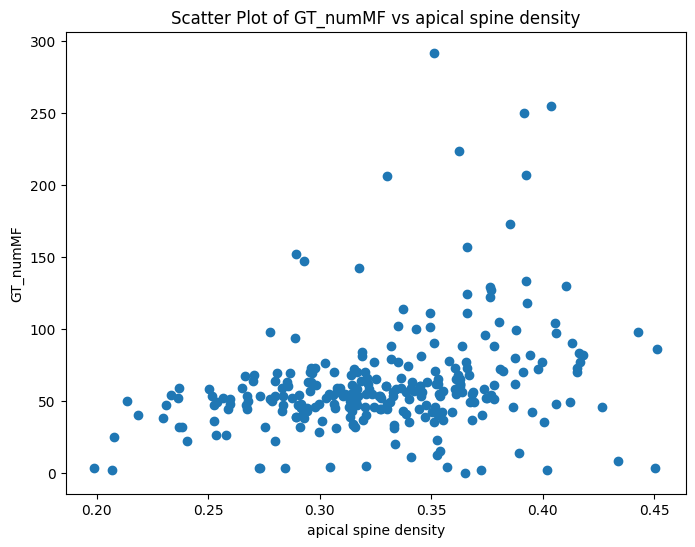

In [23]:
# Specify the columns to be used for the scatter plot
x_column = 'apical spine density' 
y_column = 'GT_numMF'  

# Check for NaNs in the specified columns and drop rows that contain them
df_clean = df_results.dropna(subset=[x_column, y_column])

# Remove rows where apical spine density is 0
df_clean = df_clean[df_clean[x_column] != 0]

print("Original number of rows:", len(df_results))
print("Number of rows after dropping NaNs:", len(df_clean))

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean[x_column], df_clean[y_column])
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f"Scatter Plot of {y_column} vs {x_column}")
plt.show()

### Graphing Depth vs. Apical Spine Density

Original number of rows: 636
Number of rows after dropping NaNs: 269


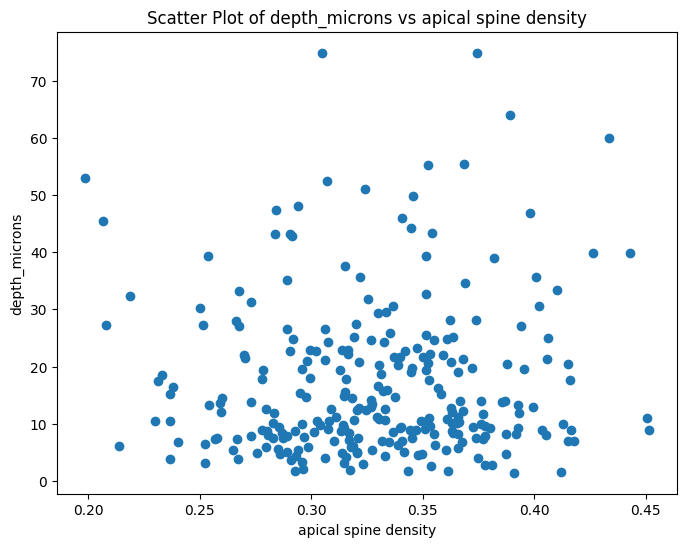

In [25]:
# Specify the columns to be used for the scatter plot
x_column = 'apical spine density'  
y_column = 'depth_microns'  

# Check for NaNs in the specified columns and drop rows that contain them
df_clean = df_results.dropna(subset=[x_column, y_column])

# Remove rows where apical spine density is 0
df_clean = df_clean[df_clean[x_column] != 0]

print("Original number of rows:", len(df_results))
print("Number of rows after dropping NaNs:", len(df_clean))

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean[x_column], df_clean[y_column])
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f"Scatter Plot of {y_column} vs {x_column}")
plt.show()